Data Import

In [23]:
import pandas as pd
import numpy as np
import tensorflow_probability as tfp
from tensorflow_probability import sts
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from matplotlib import pylab as plt
import matplotlib.dates as mdates

# Import data
elec_df = pd.read_csv(
    'PJM_Load_hourly.csv',
    names=["datetime","energy"],
    dtype={'datetime':'str', 'energy':'float'},
    parse_dates=['datetime'],
    header=0,
    skiprows = 0,
    na_values=['Null']
)

elec_df = elec_df.sort_values(by=['datetime'])
dates = elec_df['datetime']
energy = elec_df['energy']

# Take an arbritary slice of the data
start_date = '2000-03-1'
end_date = '2000-06-08'
middle_date = '2000-06-01'

# Slice data into training and testing sets
all_dates = (dates > start_date)&(dates < end_date)
training_dates = (dates > start_date)&(dates < middle_date)
testing_dates = (dates >= middle_date)&(dates < end_date)

training_data = energy[training_dates]
all_data = energy[all_dates]
dates_list = dates[all_dates]

ARIMA Model

/home/william-embecosm/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/william-embecosm/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/william-embecosm/.local/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/william-embecosm/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/william-embecosm/.local/lib/python3.6/site-packages/pandas/plotting/_converter

28368096.65966893


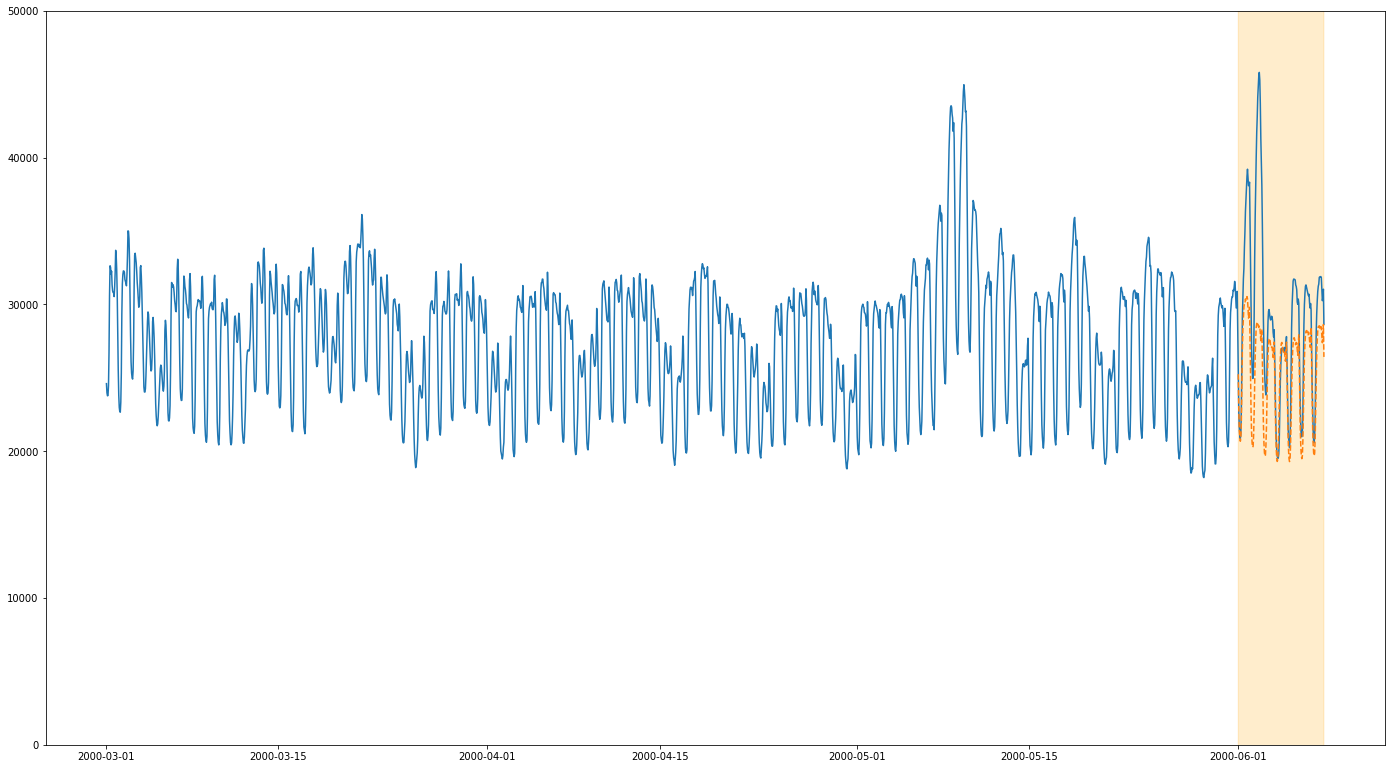

In [2]:
# Define ARIMA parameters
order = [2,2,2]
sorder = [2, 1, 2, 24]
# Fit model - this may take some time
fit = SARIMAX(endog=training_data, order=order, seasonal_order=sorder).fit()
# Create forecasts and score Model
ARIMA_forecast = fit.get_forecast(sum(testing_dates))
ARIMA_score = mean_squared_error(energy[testing_dates].values, ARIMA_forecast.predicted_mean)
print(ARIMA_score)

# Plot Model
fig, (ax) = plt.subplots(1,1,figsize=(48/2,27/2))
ax.set_ylim(0, 50000)
ax.plot(
    dates[all_dates].values,
    energy[all_dates].values,
)
ax.plot(
    dates[testing_dates].values,
    ARIMA_forecast.predicted_mean,
    linestyle = 'dashed')

ax.fill_between(
    dates[testing_dates],
    ARIMA_forecast.predicted_mean-1*ARIMA_forecast.var_pred_mean,
    ARIMA_forecast.predicted_mean+1*ARIMA_forecast.var_pred_mean,
    color='Orange',
    alpha=0.2)
#fig.savefig('plots/ARIMA_pred.png')
plt.show()

BSTS Model - One Season

Instructions for updating:
Do not call `graph_parents`.
Instructions for updating:
`MultivariateNormalFullCovariance` is deprecated, use `MultivariateNormalTriL(loc=loc, scale_tril=tf.linalg.cholesky(covariance_matrix))` instead.
Instructions for updating:
`scale_identity_multiplier` is deprecated; please combine it into `scale_diag` directly instead.
Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


/home/william-embecosm/.local/lib/python3.6/site-packages/tensorflow_probability/python/mcmc/sample.py:342: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn('Tracing all kernel results by default is deprecated. Set '


21878499.643345412


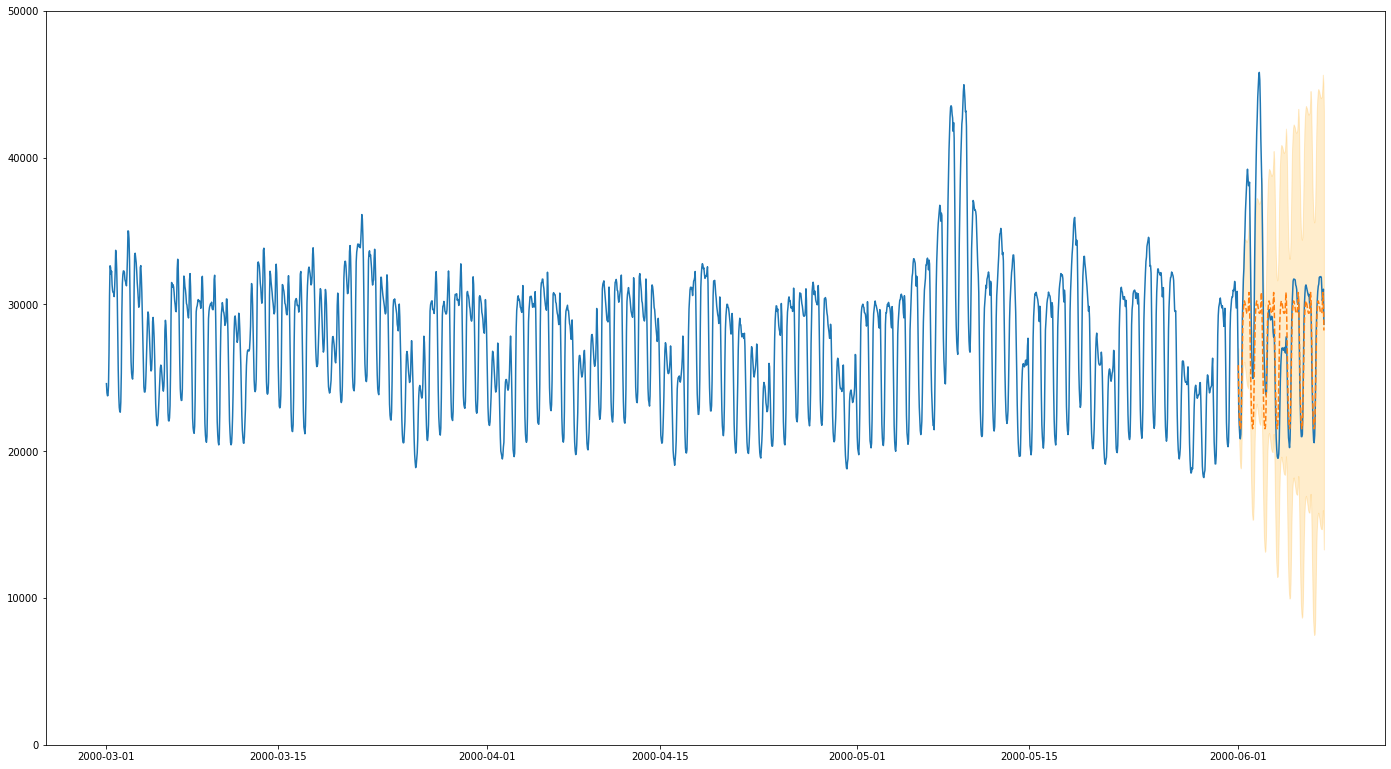

In [3]:
# Define Components of BSTS Model
trend = tfp.sts.LocalLevel(
  observed_time_series=training_data,
  name = 'trend'
)
day = tfp.sts.Seasonal(
  num_seasons = 24,
  num_steps_per_season = 1,
  observed_time_series=training_data,
  allow_drift = False,
  name = 'day'
) 
week = tfp.sts.Seasonal(
  num_seasons = 7,
  num_steps_per_season = 24,
  observed_time_series=training_data,
  allow_drift = False,
  name = 'week'
)  
model = sts.Sum(
  components = [trend, day],
  observed_time_series=training_data
)
variational_posteriors = tfp.sts.build_factored_surrogate_posterior(
    model=model)
# Fit Model. This may take some time. 
samples, kernel_results = tfp.sts.fit_with_hmc(
    model=model, observed_time_series=training_data.values)
# Create forecast and score model
findata_forecast_dist = tfp.sts.forecast(
    model = model,
    observed_time_series=training_data.values,
    parameter_samples=samples,
    num_steps_forecast=sum(testing_dates))
num_samples=100
elecdata_forecast_mean, elecdata_forecast_scale, elecdata_forecast_samples = (
    elecdata_forecast_dist.mean().numpy()[..., 0],
    elecdata_forecast_dist.stddev().numpy()[..., 0],
    elecdata_forecast_dist.sample(num_samples).numpy()[..., 0])
BSTS_score = mean_squared_error(energy[testing_dates].values, elecdata_forecast_mean)
print(BSTS_score)
# Plot data
fig, (ax) = plt.subplots(1,1,figsize=(48/2,27/2))
ax.set_ylim(0, 50000)
ax.plot(
    dates[all_dates].values,
    energy[all_dates].values,
)
ax.plot(
    dates[testing_dates].values,
    elecdata_forecast_mean,
    linestyle = 'dashed')

ax.fill_between(
    dates[testing_dates],
    elecdata_forecast_mean-2*elecdata_forecast_scale,
    elecdata_forecast_mean+2*elecdata_forecast_scale,
    color='Orange',
    alpha=0.2)
plt.show()

In [ ]:
component_dists = sts.decompose_by_component(
    model,
    observed_time_series=training_data.values,
    parameter_samples=samples)

forecast_component_dists = sts.decompose_forecast_by_component(
    model,
    forecast_dist=findata_forecast_dist,
    parameter_samples=samples)

component_means, component_stddevs = (
    {k.name: c.mean() for k, c in component_dists.items()},
    {k.name: c.stddev() for k, c in component_dists.items()})

forecast_component_means, forecast_component_stddevs= (
    {k.name: c.mean() for k, c in forecast_component_dists.items()},
    {k.name: c.stddev() for k, c in forecast_component_dists.items()}
    )
day_mean = np.concatenate(
    [component_means['day/'],
    forecast_component_means['day/']],
    axis=-1)
day_stddev = np.concatenate(
    [component_stddevs['day/'],
    forecast_component_stddevs['day/']],
    axis=-1)

trend_mean = np.concatenate(
    [component_means['trend/'],
    forecast_component_means['trend/']],
    axis=-1)
trend_stddev = np.concatenate(
    [component_stddevs['trend/'],
    forecast_component_stddevs['trend/']],
    axis=-1)

fig, (ax1, ax2) = plt.subplots(2,1,figsize=(48/2,27/2))
ax1.plot(
    dates[all_dates].values,
    day_mean,
)
ax1.fill_between(
    dates[all_dates],
    day_mean-2*day_stddev,
    day_mean+2*day_stddev,
    color='Orange',
    alpha=0.2)
ax2.plot(
    dates[all_dates].values,
    trend_mean,
)
ax2.fill_between(
    dates[all_dates],
    trend_mean-2*trend_stddev,
    trend_mean+2*trend_stddev,
    color='Orange',
    alpha=0.2)
plt.show()

BSTS Model - Two Seasons

/home/william-embecosm/.local/lib/python3.6/site-packages/tensorflow_probability/python/mcmc/sample.py:342: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn('Tracing all kernel results by default is deprecated. Set '


21805957.165566836


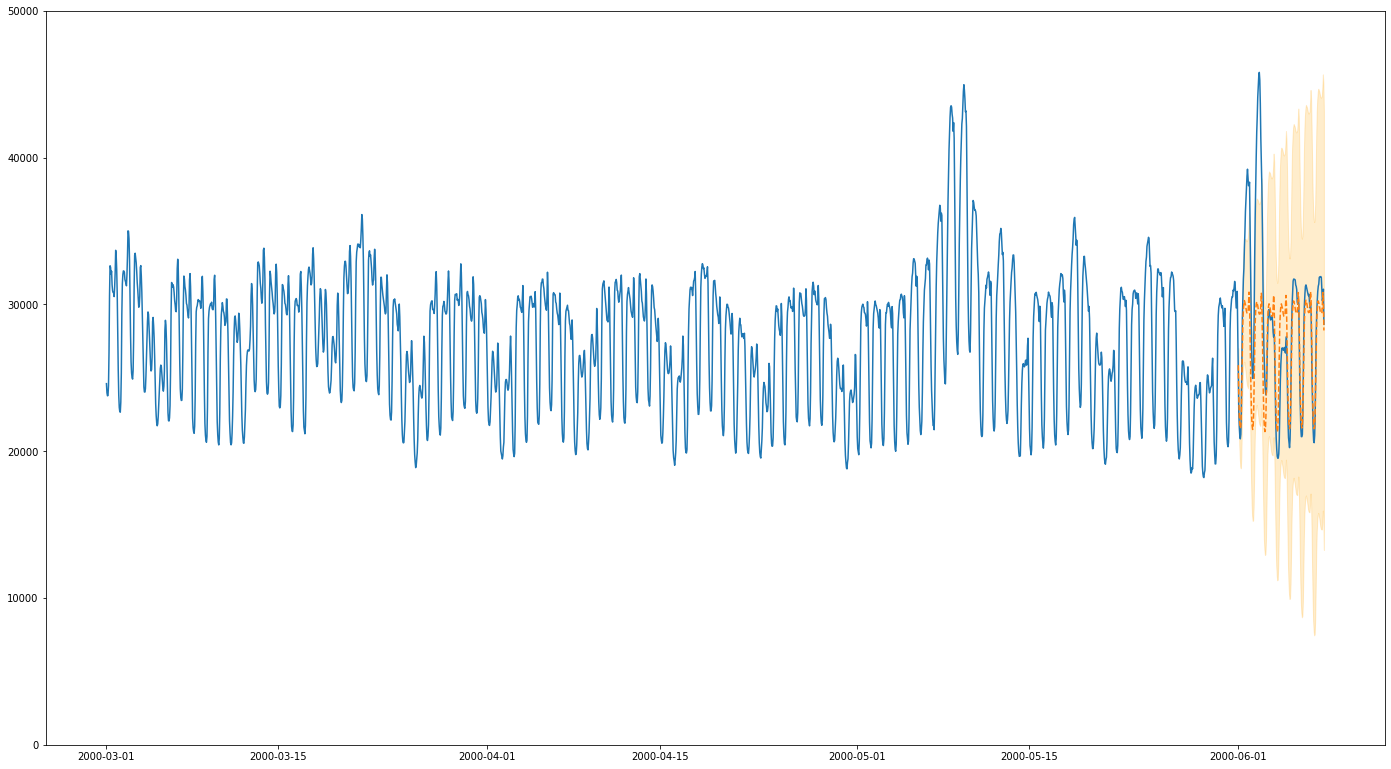

In [4]:
# Define Components of BSTS Model
trend = tfp.sts.LocalLevel(
  observed_time_series=training_data,
  name = 'trend'
)
day = tfp.sts.Seasonal(
  num_seasons = 24,
  num_steps_per_season = 1,
  observed_time_series=training_data,
  allow_drift = False,
  name = 'day'
) 
week = tfp.sts.Seasonal(
  num_seasons = 7,
  num_steps_per_season = 24,
  observed_time_series=training_data,
  allow_drift = False,
  name = 'week'
)  
model = sts.Sum(
  components = [trend, day, week],
  observed_time_series=training_data
)
variational_posteriors = tfp.sts.build_factored_surrogate_posterior(
    model=model)
# Fit Model. This may take some time. 
samples, kernel_results = tfp.sts.fit_with_hmc(
    model=model, observed_time_series=training_data.values)
# Create forecast and score model
elecdata_forecast_dist = tfp.sts.forecast(
    model = model,
    observed_time_series=training_data.values,
    parameter_samples=samples,
    num_steps_forecast=sum(testing_dates))
num_samples=100
elecdata_forecast_mean, elecdata_forecast_scale, elecdata_forecast_samples = (
    elecdata_forecast_dist.mean().numpy()[..., 0],
    elecdata_forecast_dist.stddev().numpy()[..., 0],
    elecdata_forecast_dist.sample(num_samples).numpy()[..., 0])
BSTS_score = mean_squared_error(energy[testing_dates].values, elecdata_forecast_mean)
print(BSTS_score)
# Plot data
fig, (ax) = plt.subplots(1,1,figsize=(48/2,27/2))
ax.set_ylim(0, 50000)
ax.plot(
    dates[all_dates].values,
    energy[all_dates].values,
)
ax.plot(
    dates[testing_dates].values,
    findata_forecast_mean,
    linestyle = 'dashed')

ax.fill_between(
    dates[testing_dates],
    elecdata_forecast_mean-2*elecdata_forecast_scale,
    elecdata_forecast_mean+2*elecdata_forecast_scale,
    color='Orange',
    alpha=0.2)
plt.show()

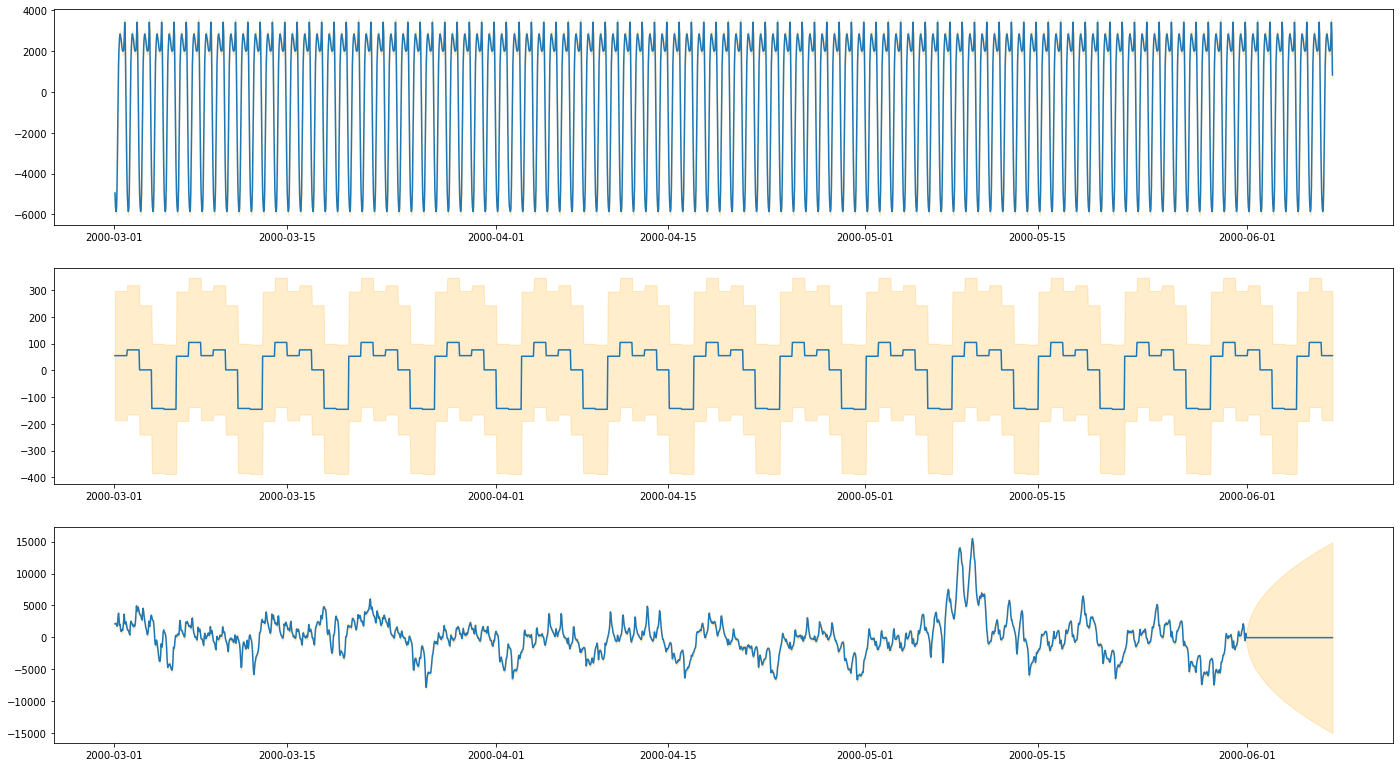

In [37]:
component_dists = sts.decompose_by_component(
    model,
    observed_time_series=training_data.values,
    parameter_samples=samples)

forecast_component_dists = sts.decompose_forecast_by_component(
    model,
    forecast_dist=findata_forecast_dist,
    parameter_samples=samples)

component_means, component_stddevs = (
    {k.name: c.mean() for k, c in component_dists.items()},
    {k.name: c.stddev() for k, c in component_dists.items()})

forecast_component_means, forecast_component_stddevs= (
    {k.name: c.mean() for k, c in forecast_component_dists.items()},
    {k.name: c.stddev() for k, c in forecast_component_dists.items()}
    )
day_mean = np.concatenate(
    [component_means['day/'],
    forecast_component_means['day/']],
    axis=-1)
day_stddev = np.concatenate(
    [component_stddevs['day/'],
    forecast_component_stddevs['day/']],
    axis=-1)

week_mean = np.concatenate(
    [component_means['week/'],
    forecast_component_means['week/']],
    axis=-1)
week_stddev = np.concatenate(
    [component_stddevs['week/'],
    forecast_component_stddevs['week/']],
    axis=-1)

trend_mean = np.concatenate(
    [component_means['trend/'],
    forecast_component_means['trend/']],
    axis=-1)
trend_stddev = np.concatenate(
    [component_stddevs['trend/'],
    forecast_component_stddevs['trend/']],
    axis=-1)

fig, (ax1, ax2, ax3) = plt.subplots(3,1,figsize=(48/2,27/2))
ax1.plot(
    dates[all_dates].values,
    day_mean,
)
ax1.fill_between(
    dates[all_dates],
    day_mean-2*day_stddev,
    day_mean+2*day_stddev,
    color='Orange',
    alpha=0.2)
ax2.plot(
    dates[all_dates].values,
    week_mean,
)
ax2.fill_between(
    dates[all_dates],
    week_mean-2*week_stddev,
    week_mean+2*week_stddev,
    color='Orange',
    alpha=0.2)
ax3.plot(
    dates[all_dates].values,
    trend_mean,
)
ax3.fill_between(
    dates[all_dates],
    trend_mean-2*trend_stddev,
    trend_mean+2*trend_stddev,
    color='Orange',
    alpha=0.2)
plt.show()

